In [6]:
# preverimo osnovne izračune
a = 3
b = 7
c = a^2 + b^2
print("Rezultat:", c)

Rezultat: 58


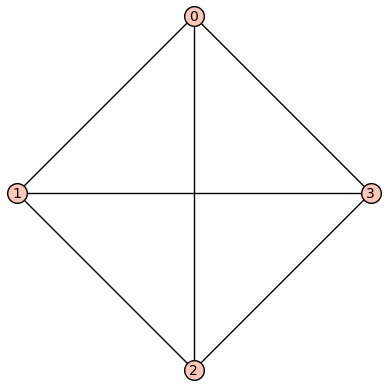

Ciklomatsko število:


In [7]:
# primer: popoln graf K4
G = graphs.CompleteGraph(4)
G.show()
print("Ciklomatsko število:",)

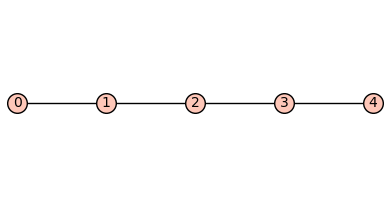

Drevo (P5):
  |V| = 5, |E| = 4,  µ(G) = 0
----------------------------------------


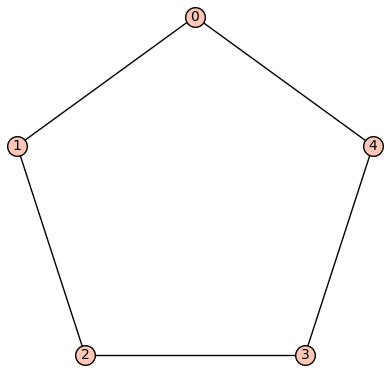

Cikel (C5):
  |V| = 5, |E| = 5,  µ(G) = 1
----------------------------------------


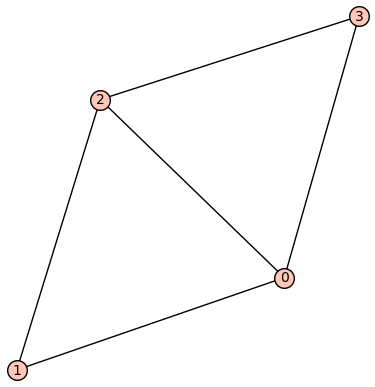

Kvadrat z diagonalo:
  |V| = 4, |E| = 5,  µ(G) = 2
----------------------------------------


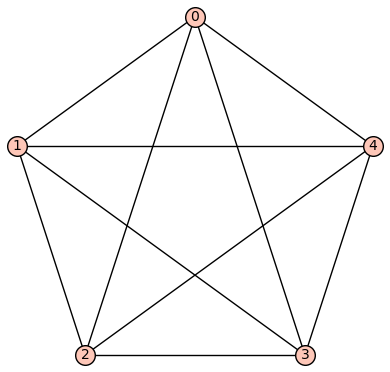

Popoln graf (K5):
  |V| = 5, |E| = 10,  µ(G) = 6
----------------------------------------


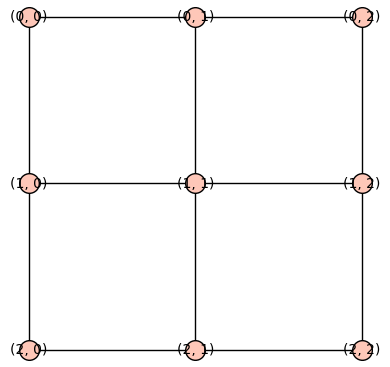

Mreža 3x3:
  |V| = 9, |E| = 12,  µ(G) = 4
----------------------------------------


In [5]:
# popravljena verzija: ciklomatsko število izračunamo ročno
def cyclomatic_number(G):
    return G.size() - G.order() + G.connected_components_number()

grafs = {
    "Drevo (P5)": graphs.PathGraph(5),
    "Cikel (C5)": graphs.CycleGraph(5),
    "Kvadrat z diagonalo": Graph([(0,1),(1,2),(2,3),(3,0),(0,2)]),
    "Popoln graf (K5)": graphs.CompleteGraph(5),
    "Mreža 3x3": graphs.Grid2dGraph(3,3)
}

for ime, G in grafs.items():
    show(G)
    print(f"{ime}:")
    print(f"  |V| = {G.order()}, |E| = {G.size()},  µ(G) = {cyclomatic_number(G)}")
    print("-"*40)

In [8]:
# primer: generiraj vse povezane grafe z n=6
n = 6
vsi_grafi = [G for G in graphs(n) if G.is_connected()]
print("Število povezanih grafov:", len(vsi_grafi))

def cyclomatic_number(G):
    return G.size() - G.order() + G.connected_components_number()

k = 2
grafi_k = [G for G in vsi_grafi if cyclomatic_number(G) == k]
print("Število grafov z µ(G)=2:", len(grafi_k))

def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for neighbor in G.neighbors(start):
        if neighbor not in visited:
            newpaths = all_simple_paths(G, neighbor, end, visited)
            for p in newpaths:
                paths.append(p)
    return paths

def subpath_number(G):
    n = 0
    V = list(G.vertices())
    for i in range(len(V)):
        for j in range(i, len(V)):
            n += len(all_simple_paths(G, V[i], V[j]))
    return n

for G in grafi_k:
    print(f"|V|={G.order()}, |E|={G.size()}, µ(G)={cyclomatic_number(G)}, p_n(G)={subpath_number(G)}")


Število povezanih grafov: 112
Število grafov z µ(G)=2: 19
|V|=6, |E|=7, µ(G)=2, p_n(G)=46
|V|=6, |E|=7, µ(G)=2, p_n(G)=52
|V|=6, |E|=7, µ(G)=2, p_n(G)=48
|V|=6, |E|=7, µ(G)=2, p_n(G)=43
|V|=6, |E|=7, µ(G)=2, p_n(G)=51
|V|=6, |E|=7, µ(G)=2, p_n(G)=49
|V|=6, |E|=7, µ(G)=2, p_n(G)=48
|V|=6, |E|=7, µ(G)=2, p_n(G)=46
|V|=6, |E|=7, µ(G)=2, p_n(G)=47
|V|=6, |E|=7, µ(G)=2, p_n(G)=48
|V|=6, |E|=7, µ(G)=2, p_n(G)=56
|V|=6, |E|=7, µ(G)=2, p_n(G)=54
|V|=6, |E|=7, µ(G)=2, p_n(G)=55
|V|=6, |E|=7, µ(G)=2, p_n(G)=53
|V|=6, |E|=7, µ(G)=2, p_n(G)=54
|V|=6, |E|=7, µ(G)=2, p_n(G)=51
|V|=6, |E|=7, µ(G)=2, p_n(G)=52
|V|=6, |E|=7, µ(G)=2, p_n(G)=48
|V|=6, |E|=7, µ(G)=2, p_n(G)=43


In [18]:
# === Projekt: Subpath number pri grafih z danim ciklomatskim številom ===
# Delo v CoCalc-u (SageMath kernel)

import itertools
from sage.all import *
import pandas as pd


# -------------------------------
# Funkcija za ciklomatsko število
# -------------------------------
def cyclomatic_number(G):
    return G.size() - G.order() + G.connected_components_number()

# -------------------------------
# Funkcija za štetje vseh enostavnih poti
# -------------------------------
def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for neighbor in G.neighbors(start):
        if neighbor not in visited:
            newpaths = all_simple_paths(G, neighbor, end, visited)
            for p in newpaths:
                paths.append(p)
    return paths

def subpath_number(G):
    """Vrne skupno število enostavnih poti (vključno z dolžino 0)."""
    V = list(G.vertices())
    n_paths = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            n_paths += len(all_simple_paths(G, V[i], V[j]))
    return n_paths

# -------------------------------
# Glavni izračun
# -------------------------------
rezultati = []  # seznam (n, µ, subpath_number)

# Za n = 3 do 7 (manjše vrednosti, da se ne zatakne)
for n in range(3, 9):
    print(f"\nObdelujem vse povezane grafe z n = {n} vozlišči ...")
    for G in graphs(n):
        if not G.is_connected():
            continue
        mu = cyclomatic_number(G)
        pn = subpath_number(G)
        rezultati.append((n, mu, pn))

print("\n--- Izračun končan ---")

# Pretvori rezultate v Sage DataFrame
df = pd.DataFrame(rezultati, columns=["n", "µ(G)", "p_n(G)"])


# Izračunaj minimalni in maksimalni subpath number za vsako kombinacijo (n, µ)
tabela = (
    df.groupby(["n", "µ(G)"])
    .agg(min_pn=("p_n(G)", "min"), max_pn=("p_n(G)", "max"), count=("p_n(G)", "count"))
    .reset_index()
)

# Izpiši tabelo rezultatov
print("\nTabela ekstremov (min / max subpath number):")
show(tabela)

# Shranimo tabelo kot CSV
tabela.to_csv("rezultati_subpath.csv", index=False)
print("\nRezultati shranjeni v datoteko 'rezultati_subpath.csv'.")


Obdelujem vse povezane grafe z n = 3 vozlišči ...

Obdelujem vse povezane grafe z n = 4 vozlišči ...

Obdelujem vse povezane grafe z n = 5 vozlišči ...

Obdelujem vse povezane grafe z n = 6 vozlišči ...

Obdelujem vse povezane grafe z n = 7 vozlišči ...

Obdelujem vse povezane grafe z n = 8 vozlišči ...

--- Izračun končan ---

Tabela ekstremov (min / max subpath number):


n  µ(G) min_pn max_pn  count
0   3     0      6      6      1
1   3     1      9      9      1
2   4     0     10     10      2
3   4     1     15     16      2
4   4     2     23     23      1
.. ..   ...    ...    ...    ...
57  8    17  17618  21680     11
58  8    18  24468  27099      5
59  8    19  32949  34058      2
60  8    20  43061  43061      1
61  8    21  54804  54804      1

[62 rows x 5 columns]


Rezultati shranjeni v datoteko 'rezultati_subpath.csv'.


In [ ]:
#izpopolnejena različica kode --> ki še ne dela
# === Projekt: Subpath number pri grafih z danim ciklomatskim številom ===
# Delo v CoCalc-u ali VS Code (SageMath kernel)

import itertools
from sage.all import *
import pandas as pd
#from tqdm.notebook import tqdm  # za prikaz napredka

# ----------------------------------
# Funkcija za ciklomatsko število
# ----------------------------------
def cyclomatic_number(G):
    """
    Izračuna ciklomatsko število grafa G:
    µ(G) = |E| - |V| + c(G),
    kjer je c(G) število povezanih komponent.
    """
    return G.size() - G.order() + G.connected_components_number()

# ----------------------------------
# Funkcija za izračun števila vseh enostavnih poti
# ----------------------------------
def subpath_number(G):
    """
    Vrne skupno število enostavnih poti (vključno z vozlišči kot poti dolžine 0).
    Uporablja vgrajeno Sage funkcijo all_simple_paths().
    """
    V = list(G.vertices())
    n_paths = len(V)  # vsako vozlišče šteje kot pot dolžine 0
    for i in range(len(V)):
        for j in range(i + 1, len(V)):
            n_paths += len(G.all_simple_paths(V[i], V[j]))
    return n_paths

# ----------------------------------
# Glavni izračun
# ----------------------------------
rezultati = []  # seznam zapisov (n, µ(G), p_n(G))

# Generiramo vse povezane grafe za n = 3 do 8
for n in range(3, 9):
    print(f"\n🔹 Obdelujem vse povezane grafe z n = {n} vozlišči ...")
    for G in graphs(n):
        if not G.is_connected():
            continue
        mu = cyclomatic_number(G)
        pn = subpath_number(G)
        rezultati.append((n, mu, pn))

print("\n✅ Izračun končan.")

# Pretvori rezultate v pandas DataFrame
df = pd.DataFrame(rezultati, columns=["n", "µ(G)", "p_n(G)"])

# Shrani vse rezultate (za nadaljnjo analizo)
df.to_csv("vsi_rezultati.csv", index=False)
print("💾 Shranjeno: vsi_rezultati.csv")

# ----------------------------------
# Tabela ekstremov (min / max subpath number)
# ----------------------------------
tabela = (
    df.groupby(["n", "µ(G)"])
    .agg(min_pn=("p_n(G)", "min"), max_pn=("p_n(G)", "max"), count=("p_n(G)", "count"))
    .reset_index()
)

print("\n📊 Tabela ekstremov (min / max subpath number):")
show(tabela)

# Shrani tudi to tabelo
tabela.to_csv("rezultati_subpath.csv", index=False)
print("💾 Shranjeno: rezultati_subpath.csv")

# ----------------------------------
# (Neobvezno) prikaz ekstremnih grafov
# ----------------------------------
prikazi_grafe = False  # spremeni na True, če želiš prikazati grafe

if prikazi_grafe:
    for (n, mu), skupina in df.groupby(["n", "µ(G)"]):
        min_pn = skupina["p_n(G)"].min()
        max_pn = skupina["p_n(G)"].max()
        print(f"\n=== n = {n}, µ(G) = {mu} ===")

        # poišči in prikaži ekstremne grafe
        for G in graphs(n):
            if not G.is_connected():
                continue
            if cyclomatic_number(G) != mu:
                continue
            pn = subpath_number(G)
            if pn == min_pn:
                print(f"Minimalni graf: p_n(G) = {pn}")
                show(G)
                break
        for G in graphs(n):
            if not G.is_connected():
                continue
            if cyclomatic_number(G) != mu:
                continue
            pn = subpath_number(G)
            if pn == max_pn:
                print(f"Maksimalni graf: p_n(G) = {pn}")
                show(G)
                break



🔹 Obdelujem vse povezane grafe z n = 3 vozlišči ...


TypeError: 'int' object is not iterable